# Réduction de la dimensionalité

Beaucoup de problèmes en ML impliquent des milliers voire des millions de features pour chaque instance d'entraînement. Non seulement ces features rendent l'entraînement extrêmement lent, mais elles peuvent aussi rendre beaucoup plus difficile la découverte d'une bonne solution. Ce problème est souvent appelé "*Malédiction de la dimensionnalité*".

Heureusement, dans les problèmes du monde réel, il est souvent possible de réduire considérablement le nombre de features, transformant un problème insoluble en un problème traitable.

Par exemple, si on considère les images du dataset MNIST : les pixels sur les bords des images sont quasiment toujours blancs, donc on pourrait complètement supprimer ces pixels du JdE sans perdre trop d'information. De plus, deux pixels voisins sont souvent hautement corrélés : si on les fusionne en un seul pixel (par ex. en prenant la moyenne de l'intensité de deux pixels), on ne perdra pas trop d'information.

*Attention* : Réduire la dimensionnalité cause une perte d'information, donc même si cela accélère l'entraînement, cela peut causer au système d'avoir de moins bonnes performances. Cela rend également les pipelines un peu plus complexes et donc plus difficiles à entretneir. Donc, si l'entraînement est trop long, on devrait d'abord essayer d'entraîner le sustème avec les données originelles avant de considérer réduire la dimensionalité. Dans certains cas, réduire la dimensionalité des données d'entraînement peut filtrer du bruit et des détails inutiles, résultant dans des performances plus élevées, mais en général ce ne sera pas le cas; cela va juste accélérer l'entraînement.

En dehors de l'accélération de l'entraînement, la réduction de dimensionalité est également extrêmement utile pour la visualisation des données (*DataViz*). Réduire le nombre de dimensions à deux ou trois rend possible de tracer une vue condensée d'un JdE de haute domensionalité sur un graphe, et souvent de gagner des informations importantes en détctant visuellement des moèdles comme des clusters. De plus, la dataviz est essentielle pour communiquer les conclusions à des personnes qui ne sont pas des data scientists.

Dans ce chapitre, on va discuter de la malédiction de la dimensionalité et avoir une idée de ce qui se passe dans un espace de haute dimension. On verra ensuite les deux principales approches de réduction de dimensionnalité (projection et Manifold Learning), puis trois des techniques de réduction de dimensionnalité les plus populaires : PCA, Kernel et LLE.

In [1]:
## Setup

#python >= 3.5 nécessaire
import sys
assert sys.version_info >= (3, 5)

#scikit-learn >= 0.20 nécessaire
import sklearn
assert sklearn.__version__ >= "0.20"

# Autres imports
import numpy as np
import os

# pour rendre les output stables au fil des runs
np.random.seed(42)

# pour tracer de jolis graphes
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# où sauvegarder les figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## La malédiction de la dimensionalité

Il est difficile de se représenter un espace à plus de trois dimensions. Même un hypercube basique en 4D est extrêmement dur à imaginer, donc n'essayons même pas pour une ellipsoïde de 200 dimensions dans un espace à 1000 dimensions.

![](fig1.png)

Il se trouve que beaucoup de choses se comportement très différemment dans un espace de haute dimensionalité. Par exemple, si on prend un point aléatoire dans un carré unité (1x1), il n'aura que 0.4% de chance d'être localisé à loins de 0.001 d'une ligne (en d'autres termes; il est très peu problable qu'un point aléatoire soit "extrême" le long de n'importe quelle dimension). Mais dans un hypercube unité de 10000 dimensions, la probabilité est plus haute que 99.99999999%. La plupart des points dans un hypercube de haute dimension sont très proches des bords.

Voici une différence encore plus troublante : si on prend deux points aléatoirement dans un carré unité, la distance entre ces deux points sera, en moyenne, 0.52. La même chose dans un cube 3D : la distance moyenne est environ 0.66. Dans un hypercube de 10000 dimensions ? 408.25. C'est contreintuitif : comment deux points peuvent peuvent être aussi éloignés quand ils sont tous les deux dans le même hypercube unité ? C'est parce qu'il y a plein d'espace dans les hautes dimensionalités. Par conséquent, les ensembles de données de grande dimension risquent d'être très clairsemés : la plupart des instances seront très loin les unes des autres. Cela veut aussi dire qu'une nouvelle instance sera très éloignée d'une instance d'entraînement, rendant les prédictions beaucoup moins fiables que dans des dimensionalités plus basses, puisuq'elles seront basées sur des extrapolations beaucoup plus grandes. En bref, plus il y a de dimensions dans un JdE, plus grand sera le risque d'overfitting.

En théorie, une solution à la malédiction serait d'augmenter la taille du JdE pour atteindre une densité suffisante pour les instances d'entraînement. Malheureusement, en pratique, le nombre d'instances d'entraînement requises pour atteindre une densité donnée augmente exponentiellement avec le nombre de dimensions. Avec seulement 100 features (significativement moins que le problème MNIST), on devrait avoir besoin de plus d'instances d'entraînement qu'il n'y d'atomes dans l'univers observable pour que les instances d'entraînement soient à 0.1 de distance moyenne l'une de l'autre, en supposant qu'elles soient réparties uniformémement au travers de toutes les dimensions.

## Approches principales pour la réduction de dimensionalité

Avant de plonger dans les algorithmes spécifiques de réduction de la dimensionalité, regardeons les deux approches principales pour la réduire : la projection et le Manifold Learning

### Projection

Dans la plupart des problèmes du monde réel, les instances d'entraînement ne sont *pas* dispersées uniformément dans toutes les dimensions. La plupart des features sont presques constantes, tanis que d'autres sont hautement corrélées (comme pour MNIST). Par conséquent, toutes les instances d'entraînement se trouvent à l'intérieur (ou proche) d'un sous-espace de dimensionalité réduite. Cela semble abstrait, mais prenons un exemple. Dans la figure suivante, on peut voir un dataset 3D réprésenté par des cercles.

Créer un jeu de données 3D :

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

#### PCA en utilisant la décomposition SVD

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

#### PCA en utilsant sklearn
Avec sklearn, la PCA devient vraiment triviale. Il s'occupe même de faire le mean centering.

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notons que lancer une PCA plusieurs fois sur des datasets légèrement différents peut avoir des résultats différents. En général, la seule différence est que quelques axes peuvent avoir été inversés. Dans les exemple, la PCA utilisant sklearn donne la même projection que celle donnée par l'approche SVD, à part deux axes échangés :

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

Récupérer les points 3D projetés sur le plan (Sous-espace PCA 2D) 

In [12]:
X3D_inv = pca.inverse_transform(X2D)

Bien sûr, il y a eu quelques pertes d'information pendant l'étape de projection, donc les points 3D récupérés ne sont pas exactement égaux aux points d'origine.

In [13]:
np.allclose(X3D_inv, X)

False

On peut calculer l'erreur de reconstruction:

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.01017033779284855

La transformation inverse dans l'approche SVD ressemble à ceci :

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

Les reconstructions des deux méthodes ne sont pas identiques car la classe PCA de Scikit-Learn se charge automatiquement d'inverser le centrage moyen, mais si on soustrait la moyenne, on obtient la même reconstruction :

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

L'objet PCA donne accès aux composantes principales qu'il a calculées :

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Comparer aux deux premières composantes principales calculées à l'aide de la méthode SVD :

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Remarquez comment les axes sont inversés.

Regardons maintenant le ratio de variance expliqué :

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

La première dimension explique 84,2 % de la variance, tandis que la seconde en explique 14,6 %.

En projetant en 2D, on a perdu environ 1,1 % de la variance :

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Voici comment calculer le ratio de variance expliqué en utilisant l'approche SVD (rappelons que s est la diagonale de la matrice S) :

In [25]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Ensuite, générons de belles figures ! :)

Classe utilitaire pour dessiner des flèches 3D (copié de http://stackoverflow.com/questions/11140163)

In [26]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Exprimer le plan en fonction de x et y.

In [27]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Tracer le jeu de données 3D, le plan et les projections sur ce plan.

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

Saving figure dataset_3d_plot


<ipython-input-28-d378521920eb>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")


AttributeError: 'Arrow3D' object has no attribute 'do_3d_projection'

AttributeError: 'Arrow3D' object has no attribute 'do_3d_projection'

<Figure size 432x273.6 with 1 Axes>

À noter que toutes les instances d'apprentissage se trouvent à proximité d'un plan : il s'agit d'un sous-espace de dimension inférieure (2D) de l'espace de grande dimension (3D). Si nous projetons chaque instance d'apprentissage perpendiculairement sur ce sous-espace (représenté par les lignes courtes reliant les instances au plan), nous obtenons le nouvel ensemble de données 2D illustré à la figure suivante. On vient de réduire la dimensionnalité du jeu de données de 3D à 2D. À noter que les axes correspondent aux nouvelles caractéristiques $z_1$ et $z_2$ (les coordonnées des projections sur le plan).

Saving figure dataset_2d_plot


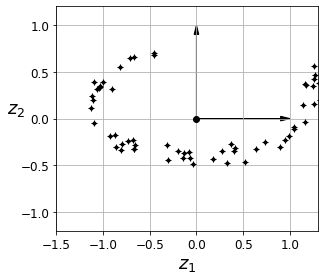

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

### Manifold Learning

à compléter